# Couple a simple single column model to the RRTMG scheme and explore ECS

The thermal structure of the atmosphere is assumed to follow the pseudoadiabatic lapse rate in the troposphere, with an overlying isothermal stratosphere at a fixed tropopause temperature, following Seeley and Jeevanjee (2020).

In [1]:
%matplotlib inline 
import climlab
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [2]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

params.RH = 0.8 

In [3]:
# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T):
    return np.divide(params.params.R_a, cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

In [4]:
def calc_olr(SST, CO2ppmv):
    ## RRTMG
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, params.Tstrat, plevs)

    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=params.RH)

    # RRTMG radiation
    rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, 
                                  albedo=0.3, ozone_file=None,
                                  absorber_vmr = {'CO2':CO2ppmv/1e6,
                                                  'CH4':0.,
                                                  'N2O':0.,
                                                  'O2':0.,
                                                  'CFC11':0.,
                                                  'CFC12':0.,
                                                  'CFC22':0.,
                                                  'CCL4':0.,
                                                  'O3':0.})
    rad.compute_diagnostics()
    olr = rad.OLR
    return olr

In [5]:
OLR0 = calc_olr(SST=288,CO2ppmv=280)
OLR0

Field([256.53037766])

In [6]:
OLRS = np.zeros((10,10))

for idx1, temp in enumerate(np.linspace(280, 290, 10)):
    for idx2, co2 in enumerate(np.linspace(280, 1200, 10)):
        OLRS[idx1, idx2] = calc_olr(temp, co2)

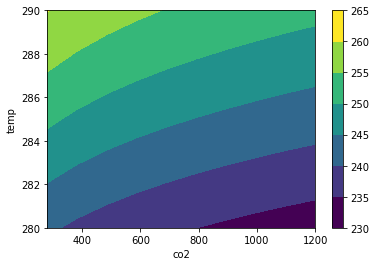

In [7]:
import xarray as xr
da=xr.DataArray(OLRS, dims=['temp', 'co2'], coords={'temp':np.linspace(280, 290, 10), 'co2':np.linspace(280, 1200, 10)})
da.plot.contourf()

# Calculate C-T$_{s}$ curve using RRTMG scheme

Loop over temperatures, and for each temperature then increment the CO$_{2}$  in 1ppmv intervals until the TOA LW energy budget is closed to within 0.2 Wm$^{-2}$ of its original value, OLR$_{0}$. 

In [8]:
"""
The loop to calculate the C-Ts curve takes ~10 minutes to run on a laptop with 
the RRTMG scheme, so you can either choose to run it or just set run_loop=False
and then it will load the data from the Data folder
"""

run_loop = False

CPU times: user 31.1 ms, sys: 2.74 ms, total: 33.9 ms
Wall time: 46.8 ms


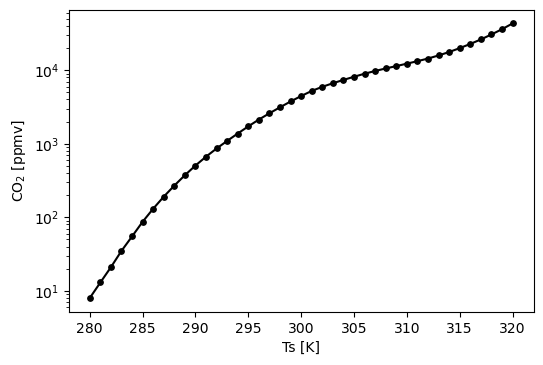

In [9]:
%%time

if run_loop:
    TEMPS = np.linspace(280, 320, 41)
    CO2_arr = np.zeros(len(TEMPS))

    OLR0 = calc_olr(SST=288,CO2ppmv=280)

    co2_init = 0

    for idx,sst in enumerate(TEMPS):

        if idx==0:
            co2_trial=co2_init

        olr = calc_olr(SST=sst,CO2ppmv=co2_trial)

        imbalance = np.round(np.abs(olr-OLR0)[0],3)

        j=0
        while imbalance>0.2:

            if j==0:
                print('Initial: ', 'SST=',int(sst), ', CO2=',int(co2_trial), ', TOA imbalance=',imbalance,' W/m2')
                amplification = 1
                j=1

            dG = (np.sign(imbalance))
            co2_trial+=dG 

            if co2_trial<0:
                co2_trial=0

            olr = calc_olr(SST=sst,CO2ppmv=co2_trial)

            imbalance = np.round(np.abs(olr-OLR0)[0],3)

        print('Final:   ', 'SST=',int(sst), ', CO2=',int(co2_trial), ', TOA imbalance=',imbalance,' W/m2')
        CO2_arr[idx] = int(co2_trial)
    
    # Save data
    C_Ts = xr.DataArray(CO2_arr, dims=['Ts'], 
                    coords={'Ts':xr.DataArray(TEMPS, dims=['Ts'], attrs={'units':'K'})},
                    attrs={'standard_name': 'CO$_{2}$', 'units': 'ppmv'})
    Ts_C = xr.DataArray(TEMPS, dims=['CO2'], 
                        coords={'CO2':xr.DataArray(CO2_arr, dims=['CO2'], attrs={'units':'ppmv'})},
                        attrs={'standard_name': 'Ts', 'units': 'K'})

    C_Ts.to_netcdf("./Data/C_Ts_curve_RRTMG.nc")
    Ts_C.to_netcdf("./Data/Ts_C_curve_RRTMG.nc")
        
    fig,ax=plt.subplots(dpi=100)
    C_Ts.plot(ax=ax, yscale='log', color='k')
    ax.scatter(C_Ts.Ts, C_Ts, color='k', s=15)
        
else:
    C_Ts = xr.open_dataarray("./Data/C_Ts_curve_RRTMG.nc")
    Ts_C = xr.open_dataarray("./Data/Ts_C_curve_RRTMG.nc")
    
    fig,ax=plt.subplots(dpi=100)
    C_Ts.plot(ax=ax, yscale='log', color='k')
    ax.scatter(C_Ts.Ts, C_Ts, color='k', s=15)

## Calculate the "inferred" ECS by interpolating along the C-T$_{s}$ curve

$$\mathrm{ECS}(\mathrm{T_{s}}) = \mathrm{T_{s}}(2\mathrm{x CO}_{2}) - \mathrm{T_{s}}(\mathrm{CO}_{2})$$

In [11]:
da_ECS = C_Ts.copy()
da_ECS.attrs = {'standard_name':'ECS', 'units': 'K'}
#da_ECS

In [13]:
for temp in da_ECS.Ts:
    conc = C_Ts.sel(Ts=temp)
    da_ECS.loc[dict(Ts=temp)] = Ts_C.interp(CO2=2*conc) - Ts_C.sel(CO2=conc) 

da_ECS
#da_ECS.to_netcdf("./Data/inferred_ECS_RRTMG.nc")

<xarray.DataArray (Ts: 41)>
array([1.375   , 1.357143, 1.35    , 1.46875 , 1.522727, 1.716667, 1.898734,
       2.060606, 2.209877, 2.410256, 2.645022, 2.849123, 3.002439, 3.114471,
       3.298507, 3.5056  , 3.728959, 3.957087, 4.453521, 5.176471, 5.948403,
       6.86125 , 7.57064 , 8.036874, 8.242692, 8.231884, 8.109218, 7.814329,
       7.421147, 6.998925, 6.524956, 6.077482, 5.595092, 5.211988, 4.86769 ,
       4.537293,      nan,      nan,      nan,      nan,      nan])
Coordinates:
  * Ts       (Ts) float64 280.0 281.0 282.0 283.0 ... 317.0 318.0 319.0 320.0
Attributes:
    standard_name:  ECS
    units:          K

Text(0.5, 1.0, 'Inferred ECS')

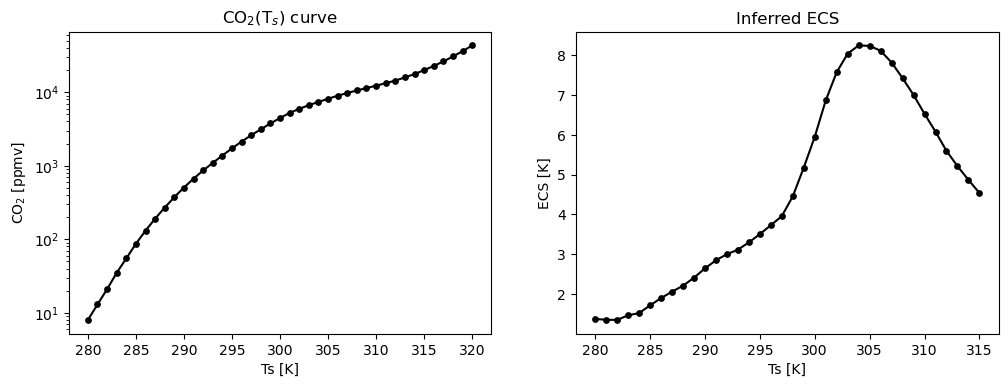

In [14]:
fig,axs=plt.subplots(ncols=2, figsize=(12,4), dpi=100)

C_Ts.plot(ax=axs[0], yscale='log', color='k')
axs[0].scatter(C_Ts.Ts, C_Ts, color='k', s=15)
axs[0].set_title(r"CO$_{2}$(T$_{s}$) curve")

da_ECS.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[1].set_title(r"Inferred ECS")

## Add illustrative example point

In [15]:
Ts_ex = 307.
co2_ex = C_Ts.sel(Ts=Ts_ex).values
Ts_ex2=Ts_C.interp(CO2=2*co2_ex).values

Text(0.5, 1.04, 'Single-column model + RRTMG scheme')

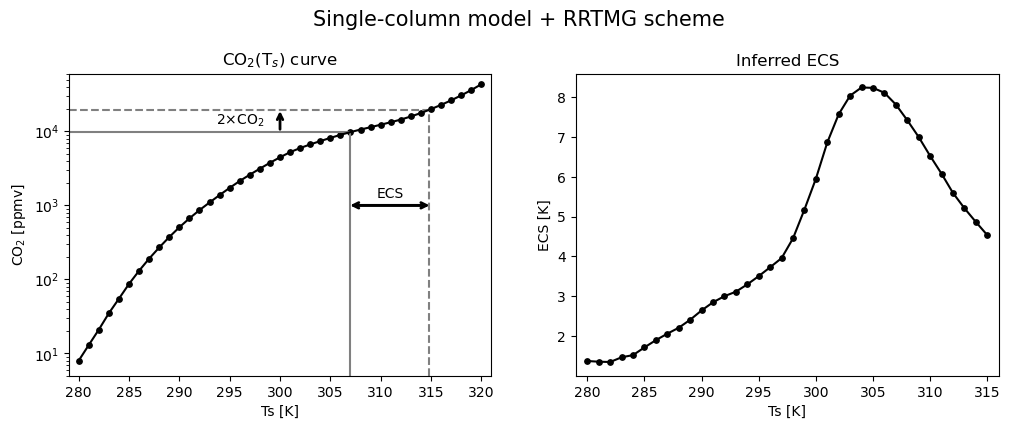

In [16]:
Tmin=279
Tmax=321
co2_min = 5
co2_max = 6e4
fig,axs=plt.subplots(ncols=2, figsize=(12,4), dpi=100)

axs[0].plot([Tmin,Ts_ex],co2_ex*np.ones(2),color='gray')
axs[0].plot([Tmin,Ts_ex2],2*co2_ex*np.ones(2),color='gray',linestyle='--')
axs[0].plot(Ts_ex*np.ones(2),[co2_min,co2_ex],color='gray')
axs[0].plot(Ts_ex2*np.ones(2),[co2_min,2*co2_ex],color='gray',linestyle='--')

axs[0].annotate("", xy=(Ts_ex/1.001, 1.e3), xytext=(Ts_ex2, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))
axs[0].annotate("", xy=(1.001*Ts_ex2, 1.e3), xytext=(Ts_ex, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))
axs[0].annotate("", xy=(300, 2.1*co2_ex), xytext=(300, co2_ex),
           arrowprops=dict(arrowstyle="->",lw=2,color='black'))

axs[0].text(0.5*(Ts_ex+Ts_ex2),1.25e3,'ECS',ha='center')
axs[0].text(296,np.sqrt(co2_ex*2*co2_ex),r'2$\times$CO$_2$',ha='center',va='center')

C_Ts.plot(ax=axs[0], yscale='log', color='k')
axs[0].scatter(C_Ts.Ts, C_Ts, color='k', s=15)
axs[0].set_xlim(Tmin, Tmax)
axs[0].set_ylim(co2_min, co2_max)
axs[0].set_title(r"CO$_{2}$(T$_{s}$) curve")

da_ECS.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[1].set_xlim(Tmin, 316)
axs[1].set_title(r"Inferred ECS")

fig.suptitle("Single-column model + RRTMG scheme", y=1.04, fontsize=15)

#plt.savefig('Example_rrtmg_fig.png',bbox_inches='tight', dpi=200)

### Calculate decomposition into F$_{2x}$ and $\lambda_{eff}$

$$\mathrm{F}_{2x}= \mathrm{OLR}(\mathrm{T}_{s}, \mathrm{C}) - \mathrm{OLR}(\mathrm{T}_{s}, 2*\mathrm{C})$$

$$\lambda_{\mathrm{eff}} = \frac{\mathrm{OLR}(\mathrm{T}_{s}+1, \mathrm{C}) - \mathrm{OLR}(\mathrm{T}_{s}, \mathrm{C})}{1\mathrm{K}}$$ 

In [18]:
da_F2x = C_Ts.copy()
da_F2x.attrs = {'standard_name':'CO2_F2x', 'units': 'W/m2'}
#da_F2x

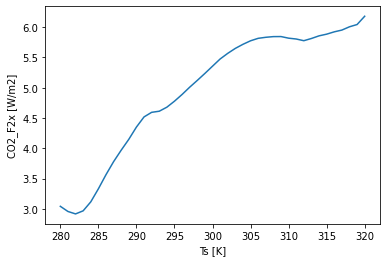

In [19]:
for temp in da_F2x.Ts:
    conc = C_Ts.sel(Ts=temp)
    da_F2x.loc[dict(Ts=temp)] = calc_olr(SST=temp.values,CO2ppmv=conc.values)[0] - calc_olr(SST=temp.values,CO2ppmv=conc.values*2)[0]
    
#sns.reset_orig()
da_F2x.plot()

In [20]:
da_lambda = C_Ts.copy()
da_lambda.attrs = {'standard_name':'Feedback_parameter', 'units': 'W/m2/K'}
#da_lambda

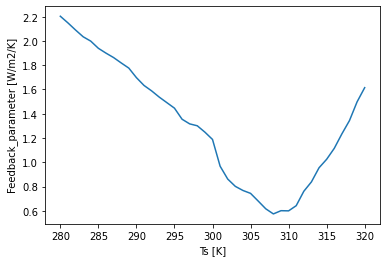

In [21]:
for temp in da_lambda.Ts:
    conc = C_Ts.sel(Ts=temp)
    da_lambda.loc[dict(Ts=temp)] = calc_olr(SST=temp.values+1,CO2ppmv=conc.values)[0] - calc_olr(SST=temp.values,CO2ppmv=conc.values)[0]
    

da_lambda.plot()

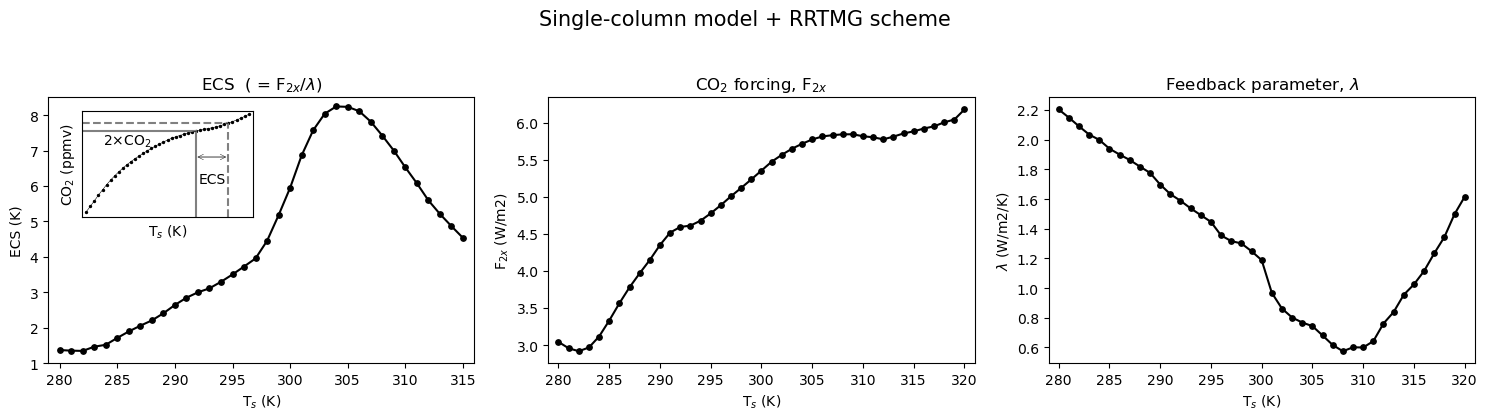

In [22]:
Tmin=279
Tmax=321
co2_min = 5
co2_max = 6e4
fig,axs=plt.subplots(ncols=3, figsize=(15,4), dpi=100)

axins = axs[0].inset_axes([0.08, 0.55, 0.4, 0.4], # x0, y0, width, height
                          transform=axs[0].transAxes) # ax[0].transAxes

axins.plot([Tmin,Ts_ex],co2_ex*np.ones(2),color='gray')
axins.plot([Tmin,Ts_ex2],2*co2_ex*np.ones(2),color='gray',linestyle='--')
axins.plot(Ts_ex*np.ones(2),[co2_min,co2_ex],color='gray')
axins.plot(Ts_ex2*np.ones(2),[co2_min,2*co2_ex],color='gray',linestyle='--')

axins.annotate("", xy=(Ts_ex/1.001, 1.e3), xytext=(Ts_ex2, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=.3,color='black'))
axins.annotate("", xy=(1.001*Ts_ex2, 1.e3), xytext=(Ts_ex, 1.e3),
           arrowprops=dict(arrowstyle="->",lw=.3,color='black'))

C_Ts.plot(ax=axins, yscale='log', color='k', lw=0.4)
axins.scatter(C_Ts.Ts, C_Ts, color='k', s=2)
axins.set_xlim(Tmin, Tmax)
axins.set_ylim(co2_min, co2_max)

axins.text(0.5*(Ts_ex+Ts_ex2),1e2,'ECS',ha='center', fontsize=10)
axins.text(290,np.sqrt(co2_ex*0.2*co2_ex),r'2$\times$CO$_2$',ha='center',va='center', fontsize=10)
axins.set_xticks([])
axins.set_yticks([])
axins.set_xlabel("T$_{s}$ (K)")
axins.set_ylabel("CO$_{2}$ (ppmv)")


da_ECS.plot(ax=axs[0], color='k')
axs[0].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[0].set_xlim(Tmin, 316)
axs[0].set_ylim(1,8.5)
axs[0].set_title(r"ECS  ( = F$_{2x}$/$\lambda$)")
axs[0].set_ylabel("ECS (K)")


da_F2x.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_F2x, color='k', s=15)
axs[1].set_xlim(Tmin, 316)
axs[1].set_title(r"CO$_{2}$ forcing, F$_{2x}$")
axs[1].set_xlim(Tmin, Tmax)
axs[1].set_ylabel(r"F$_{2x}$ (W/m2)")

da_lambda.plot(ax=axs[2], color='k')
axs[2].scatter(C_Ts.Ts, da_lambda, color='k', s=15)
axs[2].set_xlim(Tmin, 316)
axs[2].set_title("Feedback parameter, $\lambda$")
axs[2].set_xlim(Tmin, Tmax)
axs[2].set_ylabel(r"$\lambda$ (W/m2/K)")

for ax in axs:
    ax.set_xlabel("T$_{s}$ (K)")

fig.suptitle("Single-column model + RRTMG scheme", y=1.04, fontsize=15)
fig.tight_layout()

#plt.savefig('ECS_decomp_fig.png',bbox_inches='tight',facecolor='white', dpi=400)

Now, clearly the CO2 forcing is a monotonic function of temperature, at least over this range, which makes sense given the logarithmic nature of F$_{2x}$ which we're always taught in school!

This decomposition of ECS(Ts) into F$_{2x}$ and $\lambda$ makes it abundantly clear that the ECS peak is due to **a minimum in the feedback parameter** at ~310 K!

The obvious question is, why does this minimum exist? Is there some basic physics underlying it? The answer, given by Seeley and Jeevanjee in their wonderful 2020 paper "H2O windows and CO2 radiator fins: a clear-sky explanation for the peak in ECS", shows that there is in fact a fundamental clear-sky explanation for this, but to find it, we'll need to use a line-by-line code to construct a *spectrally-resolved* $\lambda$!

# Feed profiles through to PyRADS for spectrally-resolved OLR and $\lambda$

These results are sensitive to the number of pressure levels used in the calculation. I find that ~30 levels is sufficient to reproduce the results from Seeley and Jeevanjee (2020) {and Koll and Cronin (2018)}, but ideally I think you'd like to have more levels in the upper troposphere to really capture the moist adiabatic "amplification" of temperature changes.

Also, in these examples I'm going to narrow in on the wavenumber range that I'm interested in and not compute the full spectrum, this doesn't affect the results too much, but it cuts the computation time in half and so I'd say it's a reasonable approach. Feel free to spend the time computing with the full spectrum though!

One final point. In the PyRADS code, I've added a couple of lines just so that it outputs the optical depths of CO$_{2}$ ($\tau_{co2}$) and water vapour ($\tau_{h2o}$) separately, in addition to the total optical depth. It's pretty simple to do and just requires adding these lines to the `compute_tau_H2ON2_CO2_dilute` function in `OpticalThickness.py`:

```python
def compute_tau_H2ON2_CO2dilute(p,T,q,ppv_CO2,grid,params,RH=1.):

    kappa = np.zeros( (grid.Np,grid.Nn) )
    kappa_h2o = np.zeros( (grid.Np,grid.Nn) )
    kappa_co2 = np.zeros( (grid.Np,grid.Nn) )
    for pres,temp,q_H2O in zip(p,T,q):
        
        # Keep
        # this
        # the same...
        
        kappa[ p==pres,: ] = kappaH2O*q_H2O + kappaH2O_cont*q_H2O + kappaCO2*q_CO2  # save
        kappa_h2o[ p==pres,: ] = kappaH2O*q_H2O + kappaH2O_cont*q_H2O  # save
        kappa_co2[ p==pres,: ] = kappaCO2*q_CO2  # save
    print( "done! \n")

    # Integrate to get optical thickness:
    p2d = np.tile( p,(grid.Nn,1) ).T
    tau     = 1./(params.g*params.cosThetaBar) * cumtrapz( kappa,x=p2d,initial=0.,axis=0 )
    tau_h2o = 1./(params.g*params.cosThetaBar) * cumtrapz( kappa_h2o,x=p2d,initial=0.,axis=0 )
    tau_co2 = 1./(params.g*params.cosThetaBar) * cumtrapz( kappa_co2,x=p2d,initial=0.,axis=0 )
    return tau, tau_h2o, tau_co2
```

In [21]:
import os
os.chdir('/Users/andrewwilliams/Desktop/PhD/Projects/ECS_bump')

In [22]:
def calc_olr_pyrads(SST, Tstrat, CO2ppmv, dnu=0.1, nu_min=0.1, nu_max=3500, npres=30):
    ## PyRADS
    import os
    os.chdir('/Users/andrewwilliams/Desktop/PhD/Projects/PyRADS/')
    import pyrads
    import numpy as np
    from scipy.integrate import trapz,simps,cumtrapz

    class Dummy:
        pass

    params_pyrads = Dummy()

    params_pyrads.Rv = pyrads.phys.H2O.R # moist component
    params_pyrads.cpv = pyrads.phys.H2O.cp
    params_pyrads.Lvap = pyrads.phys.H2O.L_vaporization_TriplePoint
    params_pyrads.satvap_T0 = pyrads.phys.H2O.TriplePointT
    params_pyrads.satvap_e0 = pyrads.phys.H2O.TriplePointP
    params_pyrads.esat = lambda T: pyrads.Thermodynamics.get_satvps(T,
                                                              params_pyrads.satvap_T0,
                                                              params_pyrads.satvap_e0,
                                                              params_pyrads.Rv,
                                                              params_pyrads.Lvap)

    params_pyrads.R = pyrads.phys.air.R  # dry component
    params_pyrads.R_CO2 = pyrads.phys.CO2.R
    params_pyrads.cp = pyrads.phys.air.cp
    params_pyrads.ps_dry = 1e5           # surface pressure of dry component

    params_pyrads.g = 9.81             # surface gravity
    params_pyrads.cosThetaBar = 3./5.  # average zenith angle used in 2stream eqns
    params_pyrads.RH = 0.8             # relative humidity

    # setup resolution
    N_press = npres
    dwavenr = dnu

    wavenr_min = nu_min  # [cm^-1]
    wavenr_max = nu_max  #

    # setup grid:
    g = pyrads.SetupGrids.make_grid(SST,Tstrat,N_press,
                                    wavenr_min,wavenr_max,dwavenr,
                                    params_pyrads,RH=params_pyrads.RH )

    
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=N_press, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    g.p = plevs*100 # Convert hPa->Pa for PyRADS computation
    
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, Tstrat, g.p/100) # This function requires pressure in hPa !
    g.T = generate_idealized_temp_profile(SST, Tstrat, g.p/100)
    
    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=params_pyrads.RH)
    
    g.q = h2o.q
    # Set stratospheric spec hum to tropopause value (approximate)
    if np.any(g.T==Tstrat):
        mask = g.T<=Tstrat
        q_trop = g.q[~mask][0]
        g.q[mask] = q_trop
    
    # compute optical thickness:
    g.tau, g.tau_h2o, g.tau_co2 = pyrads.OpticalThickness.compute_tau_H2ON2_CO2dilute(g.p, g.T, g.q, 
                                                                                      CO2ppmv/1e6, g, 
                                                                                      params_pyrads, RH=params_pyrads.RH)
    # compute Planck functions etc:
    T_2D = np.transpose(np.tile( g.T, (g.Nn,1) )) # shape=(g.p,g.n)
    g.B_surf = np.pi* pyrads.Planck.Planck_n( g.n, SST ) # shape=(g.n)
    g.B = np.pi* pyrads.Planck.Planck_n( g.wave, T_2D ) # shape=(g.p,g.n)
    # compute OLR etc:
    olr_spec = pyrads.Get_Fluxes.Fplus_alternative(0,g) # (spectrally resolved=irradiance)
    
    return olr_spec, g

## Now, lets examine the spectral feedback parameter, $\lambda_{\nu}$, for representative low-CO$_{2}$ and high-CO$_{2}$ scenarios

It's too computationally intensive for me to do this calculation for every (C, T$_{s}$) tuple, especially just as an example, but it'd be simple enough to do if someone wanted to.

In [48]:
%%time
olr_spec1, g1 = calc_olr_pyrads(SST=282, Tstrat=200, CO2ppmv=22.3, dnu=0.1, nu_min=0.1, nu_max=1500, npres=30)
olr_spec2, g2 = calc_olr_pyrads(SST=283, Tstrat=200, CO2ppmv=22.3, dnu=0.1, nu_min=0.1, nu_max=1500, npres=30)

compute kappa at p,T =  1666.6666666666667 200.0
compute kappa at p,T =  5000.0 200.0
compute kappa at p,T =  8333.333333333334 200.0
compute kappa at p,T =  11666.666666666668 200.0
compute kappa at p,T =  15000.0 200.0
compute kappa at p,T =  18333.333333333336 200.0
compute kappa at p,T =  21666.666666666664 200.0
compute kappa at p,T =  25000.0 203.4000466056805
compute kappa at p,T =  28333.333333333336 210.7637796932034
compute kappa at p,T =  31666.666666666668 217.48810716043351
compute kappa at p,T =  35000.00000000001 223.65934699592492
compute kappa at p,T =  38333.333333333336 229.33693754574853
compute kappa at p,T =  41666.66666666667 234.56415345181355
compute kappa at p,T =  45000.00000000001 239.37563395608365
compute kappa at p,T =  48333.333333333336 243.8023088703195
compute kappa at p,T =  51666.66666666667 247.87410432239687
compute kappa at p,T =  55000.0 251.62093649077153
compute kappa at p,T =  58333.333333333336 255.0725609365744
compute kappa at p,T =  61666

In [49]:
%%time
olr_spec3, g3 = calc_olr_pyrads(SST=310, Tstrat=200, CO2ppmv=19633.5, dnu=0.1, nu_min=0.1, nu_max=1500, npres=30)
olr_spec4, g4 = calc_olr_pyrads(SST=311, Tstrat=200, CO2ppmv=19633.5, dnu=0.1, nu_min=0.1, nu_max=1500, npres=30)

compute kappa at p,T =  1666.6666666666667 200.0
compute kappa at p,T =  5000.0 200.0
compute kappa at p,T =  8333.333333333334 210.8511070654738
compute kappa at p,T =  11666.666666666668 230.4514143242041
compute kappa at p,T =  15000.0 243.82978387337158
compute kappa at p,T =  18333.333333333336 253.18643425208452
compute kappa at p,T =  21666.666666666664 260.1625109510689
compute kappa at p,T =  25000.0 265.6782164913206
compute kappa at p,T =  28333.333333333336 270.2341157338771
compute kappa at p,T =  31666.666666666668 274.1183425681077
compute kappa at p,T =  35000.00000000001 277.50826765992383
compute kappa at p,T =  38333.333333333336 280.51975316737474
compute kappa at p,T =  41666.66666666667 283.23229814123687
compute kappa at p,T =  45000.00000000001 285.7026832317628
compute kappa at p,T =  48333.333333333336 287.97284863722155
compute kappa at p,T =  51666.66666666667 290.07462301718385
compute kappa at p,T =  55000.0 292.03274162530823
compute kappa at p,T =  58333

In [90]:
# Low CO2 runs
da_olr_spec1 = xr.DataArray(olr_spec1, dims=['wavenumber'], 
                            coords={'wavenumber': xr.DataArray(g1.n, dims='wavenumber', attrs={'units':'cm$^{-1}$'})}, 
                            attrs={'standard_name': 'OLR', 'units':'W/m2/cm'})

da_olr_spec2 = xr.DataArray(olr_spec2, dims=['wavenumber'], 
                            coords={'wavenumber': xr.DataArray(g2.n, dims='wavenumber', attrs={'units':'cm$^{-1}$'})}, 
                            attrs={'standard_name': 'OLR', 'units':'W/m2/cm'})

tau_low_co2=xr.DataArray(g1.tau_co2, dims=['plev', 'wavenumber'], 
                         coords={'plev': xr.DataArray(np.log(g1.p), dims=['plev']), 'wavenumber':g1.n})

tau_low_h2o=xr.DataArray(g1.tau_h2o, dims=['plev', 'wavenumber'], 
                         coords={'plev': xr.DataArray(np.log(g1.p), dims=['plev']), 'wavenumber':g1.n})

# High CO2 runs
da_olr_spec3 = xr.DataArray(olr_spec3, dims=['wavenumber'], 
                            coords={'wavenumber': xr.DataArray(g3.n, dims='wavenumber', attrs={'units':'cm$^{-1}$'})}, 
                            attrs={'standard_name': 'OLR', 'units':'W/m2/cm'})

da_olr_spec4 = xr.DataArray(olr_spec4, dims=['wavenumber'], 
                            coords={'wavenumber': xr.DataArray(g4.n, dims='wavenumber', attrs={'units':'cm$^{-1}$'})}, 
                            attrs={'standard_name': 'OLR', 'units':'W/m2/cm'})

tau_high_co2=xr.DataArray(g3.tau_co2, dims=['plev', 'wavenumber'], 
                          coords={'plev': xr.DataArray(np.log(g3.p), dims=['plev']), 'wavenumber':g3.n})

tau_high_h2o=xr.DataArray(g3.tau_h2o, dims=['plev', 'wavenumber'], 
                          coords={'plev': xr.DataArray(np.log(g3.p), dims=['plev']), 'wavenumber':g3.n})

In [114]:
import matplotlib.patches as patches

In [ ]:
for j in range(len(h2o_windows[Ts])):
    ax1.add_patch(patches.Rectangle((h2o_windows[Ts][j][0],lamnumin),h2o_windows[Ts][j][-1]-h2o_windows[Ts][j][0],lamnumax-lamnumin,fill=True,color=pal[3],alpha=0.25))

for j in range(len(co2_radiators[Ts])):
    ax1.add_patch(patches.Rectangle((co2_radiators[Ts][j][0],lamnumin),co2_radiators[Ts][j][-1]-co2_radiators[Ts][j][0],lamnumax-lamnumin,fill=True,color=pal[0],alpha=0.25))


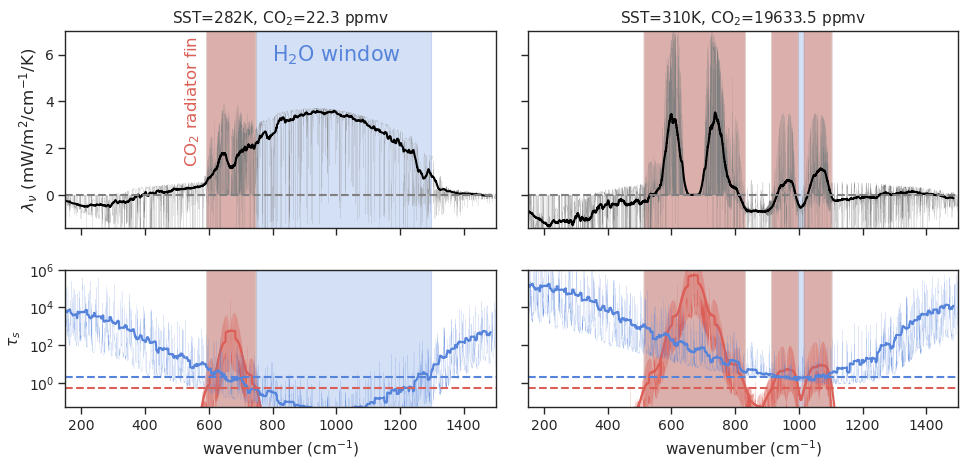

In [199]:
import seaborn as sns
sns.set_style('white')
sns.set_context('paper', font_scale=1.8)
sns.set_style('ticks')
plt.rcParams['lines.linewidth'] = 1.5
sns.set_palette('hls', 5)
pal = sns.color_palette()

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,5), dpi=100, gridspec_kw={'height_ratios':[1,0.7]})

"""
Find the CO2 radiator fins!
"""
col_co2_low = tau_low_co2.integrate('plev').rolling(wavenumber=300, center=True).mean()
nu_mask_co2_low = col_co2_low.wavenumber[~np.isnan(col_co2_low.where(col_co2_low>0.5))]
for nu in nu_mask_co2_low.wavenumber:
    axs[1,0].axvline(nu, lw=0.1, color=pal[0],alpha=0.1)
    axs[0,0].axvline(nu, lw=0.1, color=pal[0],alpha=0.1)

col_co2_high = tau_high_co2.integrate('plev').rolling(wavenumber=300, center=True).mean()
nu_mask_co2_high = col_co2_high.wavenumber[~np.isnan(col_co2_high.where(col_co2_high>0.5))]
for nu in nu_mask_co2_high.wavenumber:
    axs[1,1].axvline(nu, lw=0.1, color=pal[0],alpha=0.1)
    axs[0,1].axvline(nu, lw=0.1, color=pal[0],alpha=0.1)

"""
Find the H2O windows!
"""
                           
col_h2o_low = tau_low_h2o.integrate('plev').rolling(wavenumber=300, center=True).mean()
h2o_mask_low = col_h2o_low.wavenumber[np.logical_and(~np.isnan(col_h2o_low.where(col_h2o_low<2)), np.isnan(col_co2_low.where(col_co2_low>0.5)))]

axs[0,0].axvspan(h2o_mask_low.min(), h2o_mask_low.max(), alpha=0.25, color=pal[3])
axs[1,0].axvspan(h2o_mask_low.min(), h2o_mask_low.max(), alpha=0.25, color=pal[3])

col_h2o_high = tau_high_h2o.integrate('plev').rolling(wavenumber=300, center=True).mean()
h2o_mask_high = col_h2o_high.wavenumber[np.logical_and(~np.isnan(col_h2o_high.where(col_h2o_high<2)), np.isnan(col_co2_high.where(col_co2_high>0.5)))]

axs[0,1].axvspan(h2o_mask_high.min(), h2o_mask_high.max(), alpha=0.25, color=pal[3])
axs[1,1].axvspan(h2o_mask_high.min(), h2o_mask_high.max(), alpha=0.25, color=pal[3])

tau_low_co2.integrate('plev').sel(wavenumber=slice(150,1500)).plot(ax=axs[1,0], yscale='log', alpha=1, color=pal[0], lw=0.07)
tau_low_co2.integrate('plev').rolling(wavenumber=300, center=True).mean().sel(wavenumber=slice(150,1500)).plot(ax=axs[1,0], yscale='log', color=pal[0])

tau_low_h2o.integrate('plev').sel(wavenumber=slice(150,1500)).plot(ax=axs[1,0], yscale='log', alpha=1, color=pal[3], lw=0.07)
tau_low_h2o.integrate('plev').rolling(wavenumber=300, center=True).mean().sel(wavenumber=slice(150,1500)).plot(ax=axs[1,0], yscale='log', color=pal[3])

tau_high_co2.integrate('plev').sel(wavenumber=slice(150,1500)).plot(ax=axs[1,1], yscale='log', alpha=1, color=pal[0], lw=0.07)
tau_high_co2.integrate('plev').rolling(wavenumber=300, center=True).mean().sel(wavenumber=slice(150,1500)).plot(ax=axs[1,1], yscale='log', color=pal[0])

tau_high_h2o.integrate('plev').sel(wavenumber=slice(150,1500)).plot(ax=axs[1,1], yscale='log', alpha=1, color=pal[3], lw=0.07)
tau_high_h2o.integrate('plev').rolling(wavenumber=300, center=True).mean().sel(wavenumber=slice(150,1500)).plot(ax=axs[1,1], yscale='log', color=pal[3])



axs[0,0].text(1000, 6,r'H$_2$O window',color=pal[3],ha='center',va='center', fontsize=15)
axs[0,0].text(550, 4,r'CO$_2$ radiator fin',color=pal[0],ha='center',va='center',rotation=90, fontsize=12)

((da_olr_spec2-da_olr_spec1)*1000).sel(wavenumber=slice(150,1500)).plot(ax=axs[0,0], alpha=1, color='grey', lw=0.07)
((da_olr_spec2-da_olr_spec1)*1000).rolling(wavenumber=300, center=True).mean().sel(wavenumber=slice(150,1500)).plot(ax=axs[0,0], color='black')
axs[0,0].set_title("SST=282K, CO$_{2}$=22.3 ppmv", fontsize=11)
axs[0,0].set_ylabel(r"$\lambda_{\nu}$ (mW/m$^{2}$/cm$^{-1}$/K)", fontsize=12)

((da_olr_spec4-da_olr_spec3)*1000).sel(wavenumber=slice(150,1500)).plot(ax=axs[0,1], alpha=1, color='grey', lw=0.07)
((da_olr_spec4-da_olr_spec3)*1000).rolling(wavenumber=300, center=True).mean().sel(wavenumber=slice(150,1500)).plot(ax=axs[0,1], color='black')
axs[0,1].set_title("SST=310K, CO$_{2}$=19633.5 ppmv", fontsize=11)


for idx, ax in enumerate(axs.flatten()):
    if idx in [0,1]:
        ax.set_ylim(-1.4, 7)
        ax.set_xlabel("")
        ax.set_xticklabels([])
        if idx==1:
            ax.set_yticklabels([])
        
    if idx in [2,3]:
        ax.set_xlabel(r"wavenumber (cm$^{-1}$)", fontsize=11)
        if idx==2:
            ax.set_ylabel(r"$\tau_{s}$", fontsize=11)
        if idx==3:
            ax.set_yticklabels([])
        ax.set_ylim(5e-2, 1e6)
        ax.axhline(2,color=pal[3],linestyle='--')
        ax.axhline(0.5,color=pal[0],linestyle='--')
    
    ax.set_xlim(150, 1500)
    ax.axhline(0,color='gray',linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
#plt.savefig("/Users/andrewwilliams/Desktop/PhD/Projects/ECS_bump/high_low_co2_spectral_decomp.png", dpi=400, bbox_inches='tight', facecolor='white')
sns.reset_orig()